In [23]:
from fastai.vision.all import *
import torch, sys

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cuda


In [25]:
path = untar_data(URLs.PETS)  # Oxford-IIIT Pet dataset
imgs = (path/'images')
assert imgs.exists(), "Images folder not found after untar_data."

In [26]:
pat = r'([^/]+)_\d+.*'  # extract breed name before the underscore
# Quick validation: ensure at least some files match
sample_files = get_image_files(imgs)[:10]
assert len(sample_files) > 0, "No images found in dataset."


In [27]:
item_tfms = Resize(460)
batch_tfms = [*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]

In [28]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42, valid_pct=0.2),
    get_y=RegexLabeller(pat=pat),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

In [29]:
dls = pets.dataloaders(imgs, bs=32)
print("Classes:", len(dls.vocab), dls.vocab[:5])
print("Train batches:", len(dls.train), "Valid batches:", len(dls.valid))
assert len(dls.vocab) >= 2, "Need at least 2 classes."
assert len(dls.train) > 0 and len(dls.valid) > 0, "Train/valid loaders are empty."

Classes: 37 ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair']
Train batches: 184 Valid batches: 47


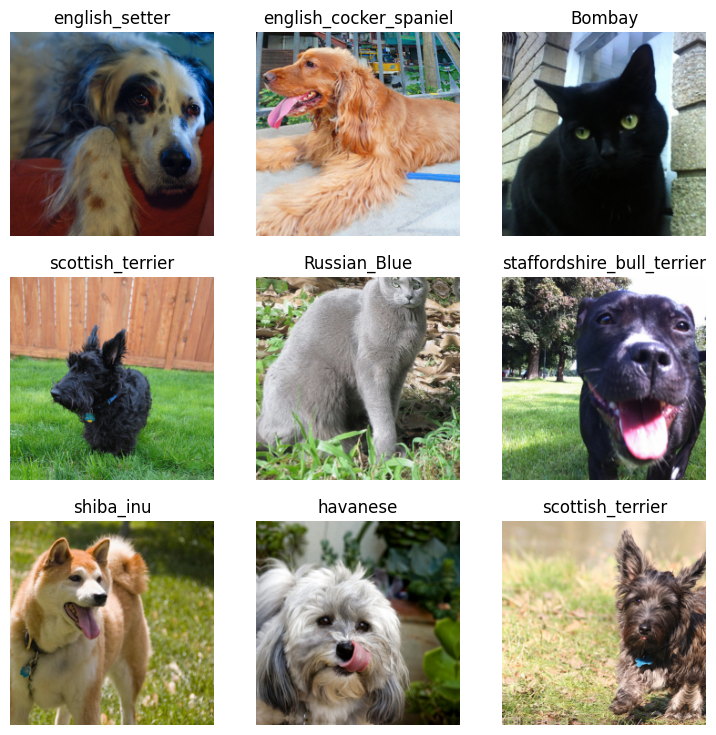

In [30]:
dls.show_batch(max_n=9)
plt.show()

In [31]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [33]:
xb, yb = dls.one_batch()
learn.model.to(device) # Move the model to the GPU
with torch.no_grad():
    out = learn.model(xb)
print("Forward pass OK. Output:", out.shape)

Forward pass OK. Output: torch.Size([32, 37])


LR suggestions: SuggestedLRs(valley=0.001737800776027143)


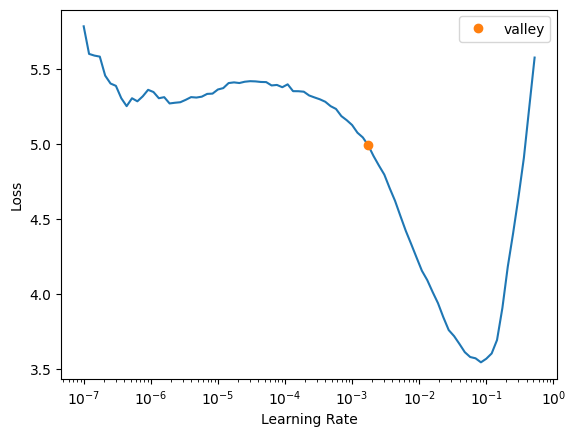

In [35]:
lr_result = learn.lr_find()
print("LR suggestions:", lr_result)
plt.show()

In [40]:
epochs = 3
lr = lr_result.valley if lr_result and lr_result.valley else 1e-3
print(f"Training for {epochs} epochs at lr={lr}")
learn.fine_tune(epochs, base_lr=lr)

Training for 3 epochs at lr=0.001737800776027143


epoch,train_loss,valid_loss,error_rate,time
0,1.083853,0.313261,0.108254,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.595121,0.316491,0.104871,01:30
1,0.372939,0.235935,0.080514,01:21
2,0.193738,0.200983,0.067659,01:21


In [41]:
rec = learn.recorder
print("Final record:", rec.final_record)
assert rec.values and len(rec.values[-1]) >= 2, "No valid metrics recorded."


Final record: [0.19373801350593567, 0.2009834200143814, 0.06765899807214737]


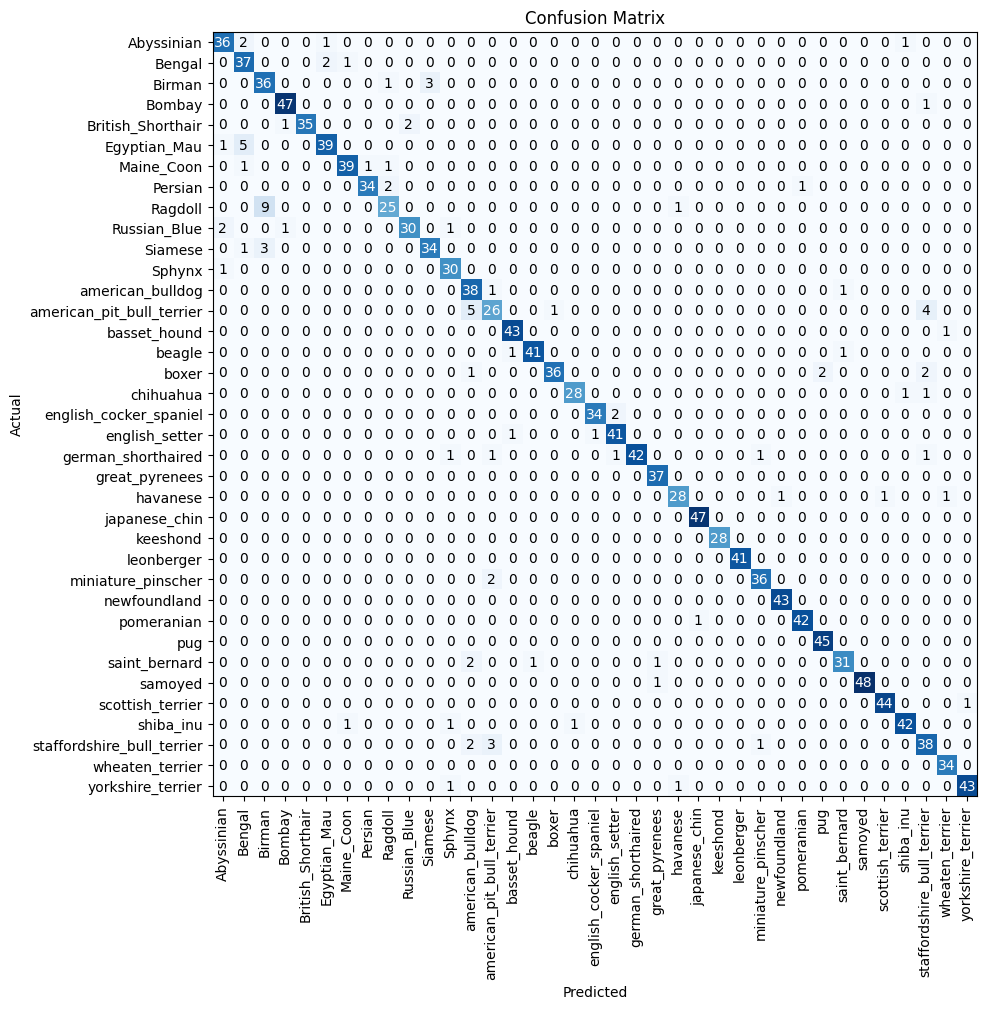

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))
plt.title("Confusion Matrix")
plt.show()

In [45]:
learn.export('export.pkl')
print("Model exported to export.pkl")

Model exported to export.pkl
